In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten,LeakyReLU,Reshape,BatchNormalization,Conv2DTranspose,Conv2D
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
(x_train, y_train), (x_test, y_test) =mnist.load_data()

num_examples = x_train.shape[0] 
num_input = x_train.shape[1]*x_train.shape[2]
num_classes = 10

x_train = x_train.reshape(60000, 28, 28, 1)
x_train = x_train.astype('float32')/255

In [ ]:
z_dim = 100

# Generator
g = Sequential()
g.add(Dense(7*7*128, input_dim=z_dim))
g.add(Reshape((7, 7, 128)))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(56, 5, strides=2, padding='same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid'))
g.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
g.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_8 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 56)        179256    
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 56)        224       
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 56)       

In [ ]:
# Discriminator
d = Sequential()
d.add(Conv2D(56, 5, strides=2, padding='same', input_shape=(28, 28, 1), activation=LeakyReLU(alpha=0.2)))
d.add(Conv2D(128, 5, strides=2, padding='same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Conv2D(224, 5, strides=2, padding='same'))
g.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Flatten())
d.add(Dense(112, activation=LeakyReLU(alpha=0.2)))
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
d.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 56)        1456      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)         179328    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 224)         717024    
_________________________________________________________________
flatten_2 (Flatten)          (None, 3584)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 112)               401520    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 113       
Total params: 1,299,441
Trainable params: 1,299,441
Non-trainable params: 0
____________________________________________

In [ ]:
# GAN
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
losses = {"D":[], "G":[]}

def train(n_ex = 10,epochs=1, timesteps=1, batch_size=128):
    for i in range(1, epochs+1):
        for _ in range(int(x_train.shape[0] / batch_size)):  
            # Batch size composed of half real images, half fake images
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            fake_images = g.predict(noise)
            X = np.concatenate((image_batch, fake_images))

            # Labels 1 = real ; 0 : fake
            y = np.zeros(2*batch_size)
            y[:batch_size] = 1

            # Train D on the dataset
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train G (freeze D)
            noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            y2 = np.ones(batch_size)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # losses
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Intermediate results every timesteps
        print("epoch "+str(i))
        if i == 1 or i%timesteps== 0:
            noise = np.random.normal(0, 1, size=(n_ex, z_dim))
            fake_images = g.predict(noise).reshape(n_ex, 28, 28)

            plt.figure(figsize=(12,2))
            for j in range(fake_images.shape[0]):
                plt.subplot(1, n_ex, j+1)
                plt.imshow(fake_images[j], interpolation='nearest', cmap='gray_r')
                plt.axis('off')
            plt.title("Epoch "+str(i))
            plt.tight_layout()
            plt.savefig('image_{:04d}.png'.format(i),dpi=100) 
            plt.close()

    d_acc = [v[1] for v in losses["D"]]
    g_acc = [v[1] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_acc, label="Discriminator accuracy")
    plt.plot(g_acc, label="Generator accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## GAN on all the dataset

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110
epoch 11

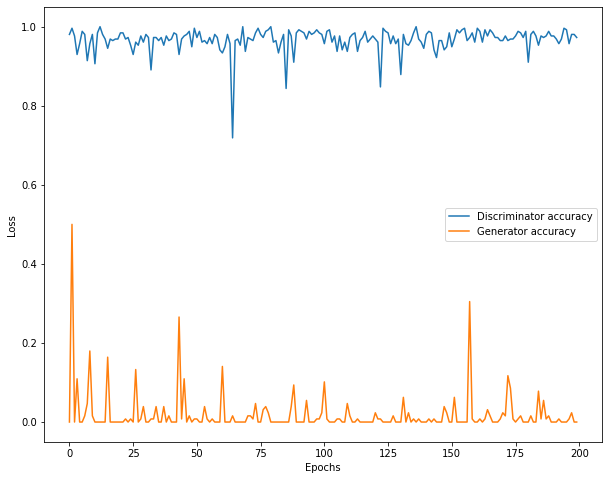

In [ ]:
train(n_ex=10, epochs=200, timesteps=20, batch_size=128)

In [ ]:
PATH_TO_ROOT = "/content/drive/MyDrive/Colab-Notebooks/Deep-Learning-Python/10-gan/"

In [ ]:
gan.save_weights(PATH_TO_ROOT + 'DCGANMNIST.h5')

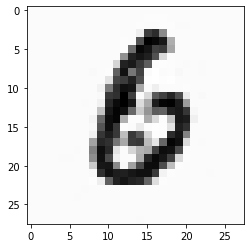

In [28]:
noise = np.random.normal(0, 1, size=(1, z_dim))
x = g.predict(noise)
x = x.reshape(28,28)
plt.imshow(x, interpolation='nearest', cmap='gray_r')

## GAN on one digit



epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110
epoch 11

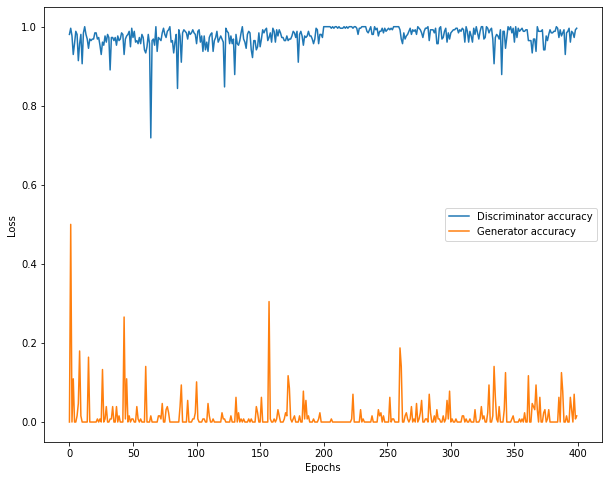

In [ ]:
(x_train, y_train), (x_test, y_test) =mnist.load_data()

num_examples = x_train.shape[0] 
num_input = x_train.shape[1]*x_train.shape[2]
num_classes = 10

x_train = x_train.reshape(60000, 28, 28, 1)
x_train = x_train.astype('float32')/255

train_filter = np.where((y_train == 6 ) )
x_train = x_train[train_filter]
train(n_ex= 10, epochs=200, timesteps=1, batch_size=128)
gan.save_weights(PATH_TO_ROOT + 'DCGANMNIST_6.h5')

In [ ]:
anim_file = 'GANMNIST.gif'
import imageio
import glob


with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
# to be done 1 time
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.